In [1]:
import cv2, pygame
import numpy as np
from scipy.signal import medfilt
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Define function for making binary
def make_binary(img, threshold):

    img[img >= threshold] = 255
    img[img < threshold] = 0
    
    return img

# Test binary function
binary_seed = np.array([[124, 125, 126, 0], [0, 255, 255, 0], [255, 0, 255, 0], [0, 0, 0, 0]])
threshold = 125

make_binary(binary_seed, threshold)

array([[  0, 255, 255,   0],
       [  0, 255, 255,   0],
       [255,   0, 255,   0],
       [  0,   0,   0,   0]])

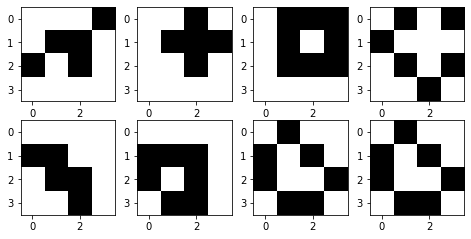

In [49]:
# Define function for Game of Life
def GoL(seed, n_generations):
    # Empty list for appending generations to (and start with the seed)
    generations = []

    generations.append(seed)
    
    # Apply 0-padding
    seed = np.pad(seed, 1)

    # Define n_rows and n_cols from shape of img
    n_rows, n_cols = seed.shape

    # Perform ticks
    for i in range(n_generations):
        # Create image for next step, for overwriting
        generation = np.array(np.zeros(shape=(n_rows, n_cols), dtype=np.int32))
        
        # For loop that iterates over each cell in the array
        for r in range(n_rows-2):
            
            for c in range(n_cols-2):
                
                # seed[r+1, c+1] and sum_context has the right information. Check with: print(seed[r+1, c+1]) and print(sum_context)
                sum_context = seed[r, c] + seed[r, c+1] + seed[r, c+2] + seed[r+1, c] + seed[r+1, c+2] + seed[r+2, c] + seed[r+2, c+1] + seed[r+2, c+2]

                # Any live cell with fewer than 2 or more than 3, dies
                if seed[r+1, c+1] == 1*255:
                    if sum_context < 2*255 or sum_context > 3*255:
                        generation[r+1, c+1] = 0
                
                # Any live cell with two or three live neighbours lives, unchanged
                if seed[r+1, c+1] == 1*255 and 4*255 > sum_context > 1*255:
                    generation[r+1, c+1] = 1*255

                # Any dead cell with exactly 3 three live neighbours will come to life
                if seed[r+1, c+1] == 0 and sum_context == 3*255:
                    generation[r+1, c+1] = 1*255
        
        seed = generation.copy()

        generations.append(generation[1:-1, 1:-1])
        
    return generations


# Test functions:
seed = np.array([[0, 0, 0, 255], [0, 255, 255, 0], [255, 0, 255, 0], [0, 0, 0, 0]])
n_generations = 7

# Run function
generations = GoL(seed, n_generations)

# Plot generations
fig = plt.figure(figsize=(8, 8))
columns = len(generations)//2
rows = len(generations)//2
for i in range(1, len(generations)+1):
    generations[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(generations[i-1], cmap="gray_r")
plt.show()

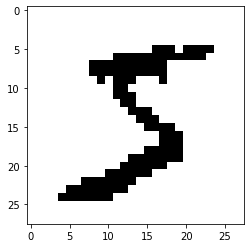

In [50]:
# Load data (train_X is subsetted)
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X[:1000,]

# Make data binary
train_X_binary = [make_binary(img.copy(), 125) for img in train_X]

# Plot an image
plt.imshow(train_X_binary[0], cmap="gray_r")

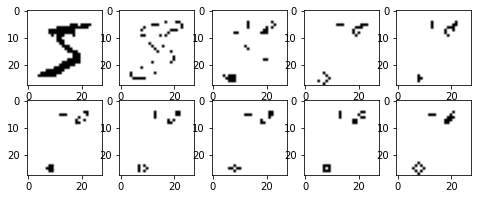

In [57]:
seed = np.array(train_X_binary[0], dtype=np.int32)
n_generations = 9
generations = GoL(seed, n_generations)

# Plot generations
fig = plt.figure(figsize=(8, 8))
columns = len(generations)//2
rows = len(generations)//2
for i in range(1, len(generations)+1):
    generations[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(generations[i-1], cmap="gray_r")
plt.show()

In [ ]:
# Function for applying kernel any number of iterations with "basic" kernel
def iterated_kernel(img, kernel, iterations):
    
    for i in range(iterations):
        img = cv2.filter2D(img, -1, kernel)
    
    return img

# Test function
img_orig = np.array([[124, 125, 126, 0], [0, 255, 255, 0], [255, 0, 255, 0], [0, 0, 0, 0]])
img_bina = make_binary(img_orig.copy(), 125)

print(img_orig)
print(img_bina)

kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

cv2.filter2D(img_orig, -1, kernel)

# img_iterated_once = iterated_kernel(img_bina, kernel, 1)
# img_iterated_twice = iterated_kernel(img_bina, kernel, 2)

# Plotting different versions
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_orig, cmap='gray_r')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_bina, cmap='gray_r')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_iterated_once, cmap='gray_r')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_iterated_twice, cmap='gray_r')